In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

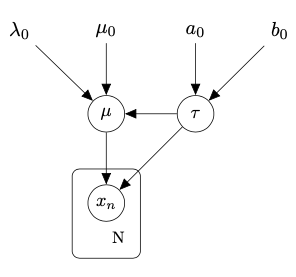

### ***Question 1.3.9:***

Implement a function that generates data points for the given model.

In [2]:
def generate_data(mu, tau, N):
  """Draw N samples from N(mu, tau^{-1}) and return them as a NumPy array."""
  if tau <= 0:
    raise ValueError("Precision tau must be positive.")

  std = np.sqrt(1.0 / tau)
  D = np.random.normal(loc=mu, scale=std, size=N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



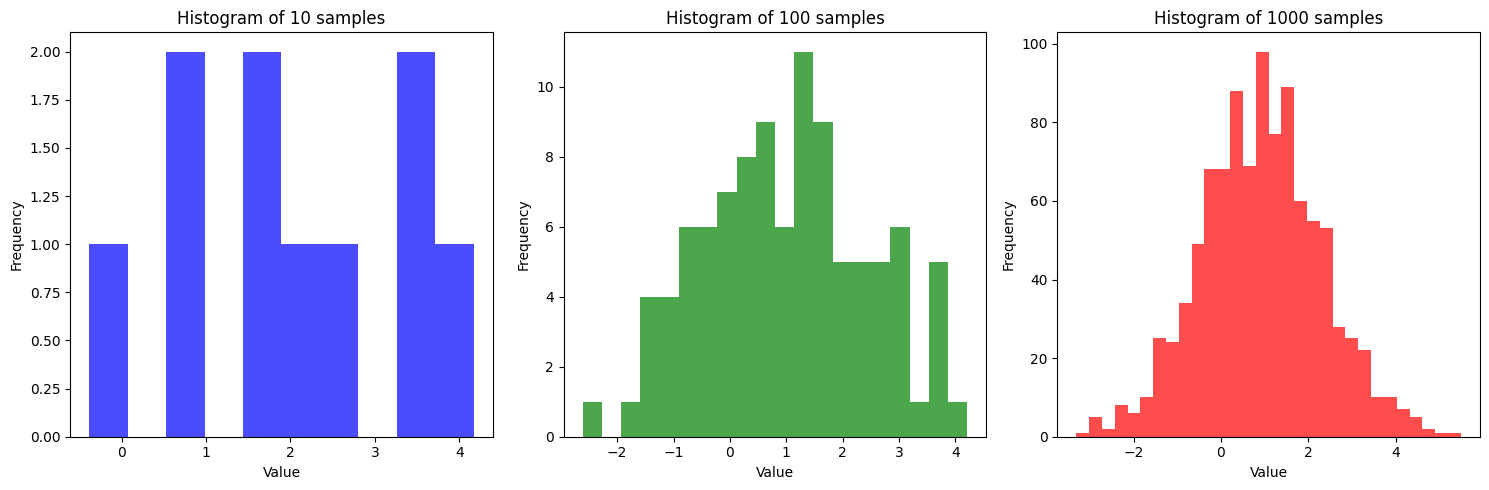

In [3]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here

#Plot histograms of the data:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataset_1, bins=10, alpha=0.7, color='blue')
plt.title('Histogram of 10 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataset_2, bins=20, alpha=0.7, color='green')
plt.title('Histogram of 100 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataset_3, bins=30, alpha=0.7, color='red')
plt.title('Histogram of 1000 samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()




### ***Question 1.3.10:***

Find ML estimates of the variables μ and τ

In [4]:
def ML_est(data):
  mean = np.mean(data)
  N = len(data)
  mu_ml = mean
  tau_ml = N / np.sum((data - mean) ** 2)
  # insert your code
  return mu_ml, tau_ml

### ***Question 1.3.11:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [5]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
  N = len(D)
  x_bar = np.mean(D)
  lambda_n = lambda_0 + N
  mu_n = (lambda_0 * mu_0 + N * x_bar) / (lambda_0 + N)
  b_n = b_0 + 0.5 * np.sum((D - x_bar) ** 2) + ((lambda_0*N)/(2*(lambda_0 + N))) * (x_bar - mu_0)**2
  a_n = a_0 + N / 2
  return lambda_n, mu_n, a_n, b_n

### ***Question 1.3.12:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [6]:
# prior parameters
mu_0 =1.0
lambda_0 =0.1
a_0 =1.0
b_0 =2.0

Continue with a helper function that computes ELBO:


In [7]:
from scipy.stats import gamma, norm
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO
  """
    Variational ELBO for the univariate Gaussian with Normal-Gamma prior,
    using a mean-field approximation q(mu) q(tau).

    q(mu)  = N(mu_N, (lambda_N)^(-1))
    q(tau) = Gam(a_N, b_N)   [shape a_N, rate b_N]

    ELBO is computed up to an additive constant independent of variational params.
    """
  D = np.asarray(D)
  N = len(D)

  # Variational distributions
  q_tau = gamma(a_N, scale=1.0 / b_N)          # shape a_N, rate b_N -> scale = 1/b_N
  q_mu  = norm(loc=mu_N, scale=np.sqrt(1.0 / lambda_N))

  # Moments under q(tau)
  E_tau = q_tau.mean()
  E_log_tau = q_tau.expect(np.log)

  # Moments under q(mu)
  var_mu = 1.0 / lambda_N
  E_mu = mu_N

  # E[(x_n - mu)^2] = (x_n - E[mu])^2 + Var(mu)
  sq_diff = (D - E_mu) ** 2 + var_mu
  sum_sq_diff = np.sum(sq_diff)

  # ----- Expected log joint p(D, mu, tau) -----
  # 1) E_q[ log p(D | mu, tau) ]
  #    log p(D|mu,tau) = N/2 log tau - (tau/2) sum_n (x_n - mu)^2 + const
  E_log_p_D = 0.5 * N * E_log_tau - 0.5 * E_tau * sum_sq_diff

  # 2) E_q[ log p(mu | tau) ],  p(mu|tau) = N(mu_0, (lambda_0 * tau)^(-1))
  #    log p(mu|tau) = 0.5 log(lambda_0 tau) - 0.5 lambda_0 tau (mu - mu_0)^2 + const
  E_mu_minus_mu0_sq = (E_mu - mu_0) ** 2 + var_mu
  E_log_p_mu_given_tau = (
      0.5 * E_log_tau
      + 0.5 * np.log(lambda_0)
      - 0.5 * lambda_0 * E_tau * E_mu_minus_mu0_sq
  )

  # 3) E_q[ log p(tau) ],  p(tau) = Gam(a_0, b_0)
  #    log p(tau) = (a_0 - 1) log tau - b_0 tau + const
  E_log_p_tau = (a_0 - 1) * E_log_tau - b_0 * E_tau

  E_log_joint = E_log_p_D + E_log_p_mu_given_tau + E_log_p_tau

  # ----- Entropy H[q] = H[q(mu)] + H[q(tau)] -----
  H_mu = q_mu.entropy()
  H_tau = q_tau.entropy()

  elbo = E_log_joint + H_mu + H_tau
  return elbo


Now, implement the CAVI algorithm:

In [8]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau =a_0 / b_0

  # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence
    # Use ELBO function defined above
  exp_tau = initial_guess_exp_tau
  elbos = []
  elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_0, b_0, mu_0, lambda_0))
  N = len(D)
  x_bar = np.mean(D)
 
  while len(elbos) < 2 or abs(elbos[-1] - elbos[-2]) > 1e-6:

    # Update q(mu) using current expected value of tau
    lambda_N = (lambda_0 + N )* exp_tau
    mu_N = (lambda_0 * mu_0 + N * x_bar) / (lambda_0 + N)
    
    # Update q(tau) using current q(mu)
    a_N = a_0 + (N+1)/ 2
    b_N = b_0 + 0.5 *(np.sum((D-mu_N)**2 + 1/lambda_N) +
                      lambda_0 * ((mu_N - mu_0)**2 + 1/lambda_N))
    
    exp_tau = a_N / b_N
    elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
    elbos.append(elbo)

  return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


[np.float64(-38.91080630255813), np.float64(-11.247841206850524), np.float64(-11.247242279131493), np.float64(-11.24723861283724), np.float64(-11.247238591085335)]


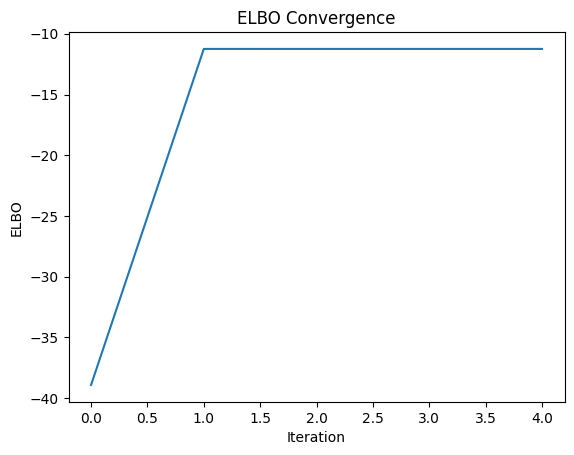

/var/folders/pm/1gbbgm994d3fgrqz_vmjbwbw0000gn/T/ipykernel_43504/302022840.py:23: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(Mu, Tau, Z_true, levels=5, colors='blue', alpha=0.5, label='True Posterior')
/var/folders/pm/1gbbgm994d3fgrqz_vmjbwbw0000gn/T/ipykernel_43504/302022840.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(Mu, Tau, Z_cavi, levels=5, colors='red', alpha=0.5, label='CAVI Approximation')


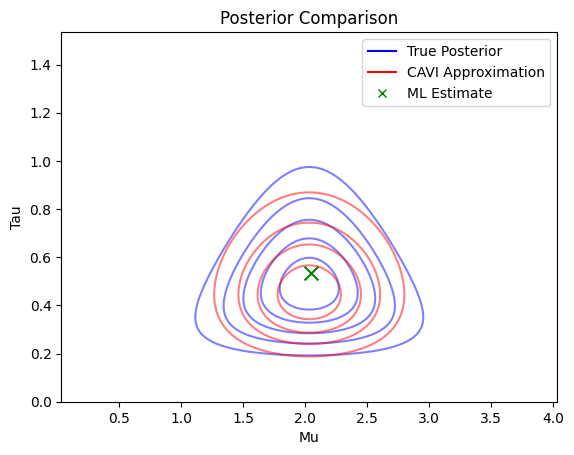

[np.float64(-367.0930384458827), np.float64(-93.22720170609706), np.float64(-93.22619290253895), np.float64(-93.22619281143119)]


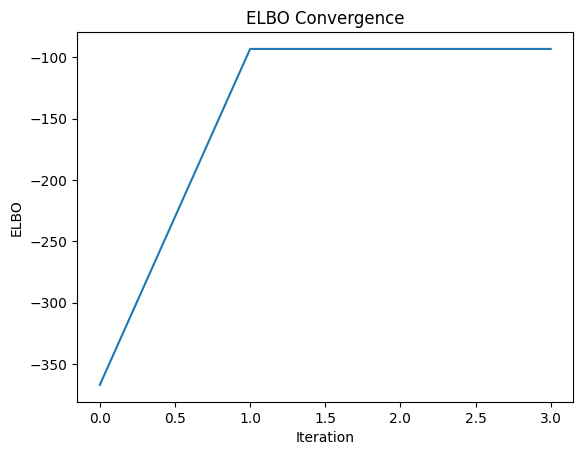

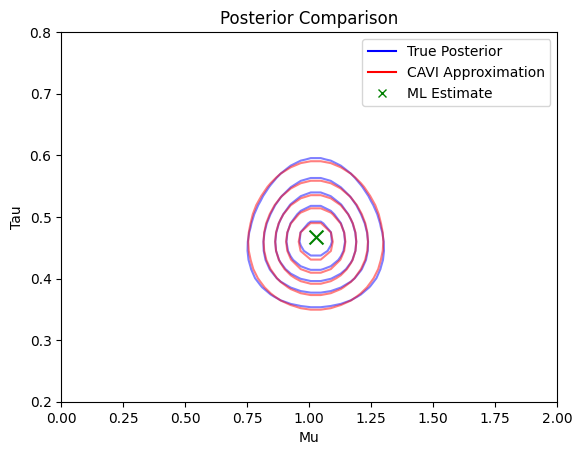

[np.float64(-3607.6325667895157), np.float64(-824.1262144394088), np.float64(-824.1252997434171), np.float64(-824.1252997424643)]


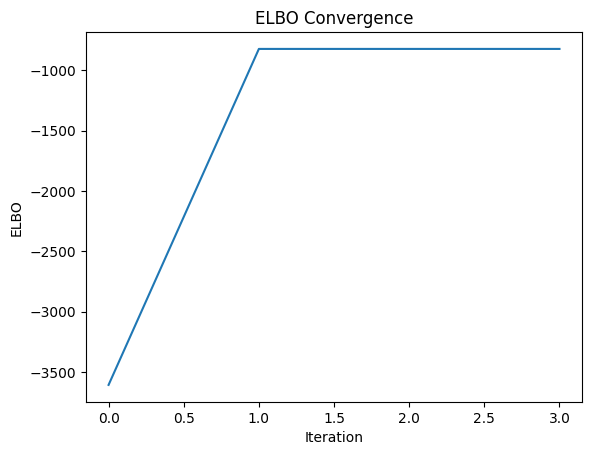

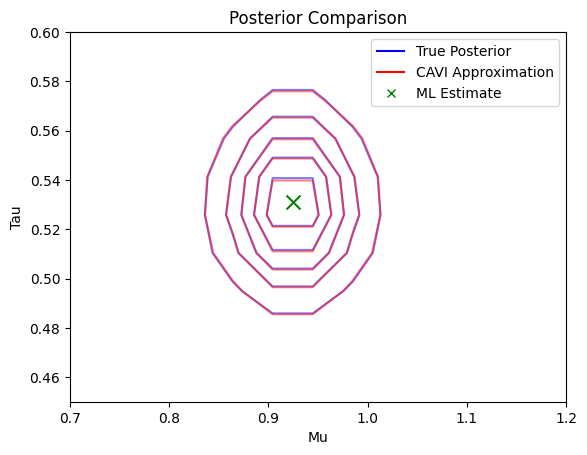

In [15]:
# Insert your main code here
from matplotlib.lines import Line2D
i = 0
for data in [dataset_1, dataset_2, dataset_3]:
    mu_ml, tau_ml = ML_est(data)
    a_N, b_N, mu_N, lambda_N, elbos = CAVI(data, a_0, b_0, mu_0, lambda_0)
    print(elbos)
    # plot elbos, show convergence
    plt.plot(elbos)
    plt.title('ELBO Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')
    plt.show()
    lambda_true, mu_true, a_true, b_true = compute_exact_posterior(data, a_0, b_0, mu_0, lambda_0)
    # compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot
    mu_grid = np.linspace(mu_true - 2, mu_true + 2, 100)
    tau_grid = np.linspace(0.0001, tau_ml + 1, 100)
    Mu, Tau = np.meshgrid(mu_grid, tau_grid)
    #True pdf is normal-gamma with parameters from exact posterior
    Z_true = gamma.pdf(Tau, a_true, scale=1.0 / b_true) * norm.pdf(Mu, loc=mu_true, scale=np.sqrt(1.0 / (lambda_true * Tau)))
    #CAVI pdf is normal-gamma with parameters from CAVI
    Z_cavi = gamma.pdf(Tau, a_N, scale=1.0 / b_N) * norm.pdf(Mu, loc=mu_N, scale=np.sqrt(1.0 / lambda_N))
    plt.contour(Mu, Tau, Z_true, levels=5, colors='blue', alpha=0.5, label='True Posterior')
    plt.contour(Mu, Tau, Z_cavi, levels=5, colors='red', alpha=0.5, label='CAVI Approximation')
    #Set axis limits to focus on relevant area
    
    plt.scatter(mu_ml, tau_ml, color='green', marker='x', s=100, label='ML Estimate')
    plt.xlim(mu_true - 2, mu_true + 2)
    plt.ylim(0, tau_ml + 1)
    if i == 1:
        plt.xlim(0,2)
        plt.ylim(0.2, 0.8)
    if i == 2:
        plt.xlim(0.7,1.2)
        plt.ylim(0.45, 0.6)
    # Legend (manual proxy artists)
    legend_items = [
    Line2D([], [], color='blue', label='True Posterior'),
    Line2D([], [], color='red', label='CAVI Approximation'),
    Line2D([], [], color='green', marker='x', linestyle='None', label='ML Estimate')
    ]
    plt.legend(handles=legend_items)
    plt.title('Posterior Comparison')
    plt.xlabel('Mu')
    plt.ylabel('Tau')
    plt.show()
    i += 1
